In [ ]:
##the following below shows how to present the data to the athletic trainers

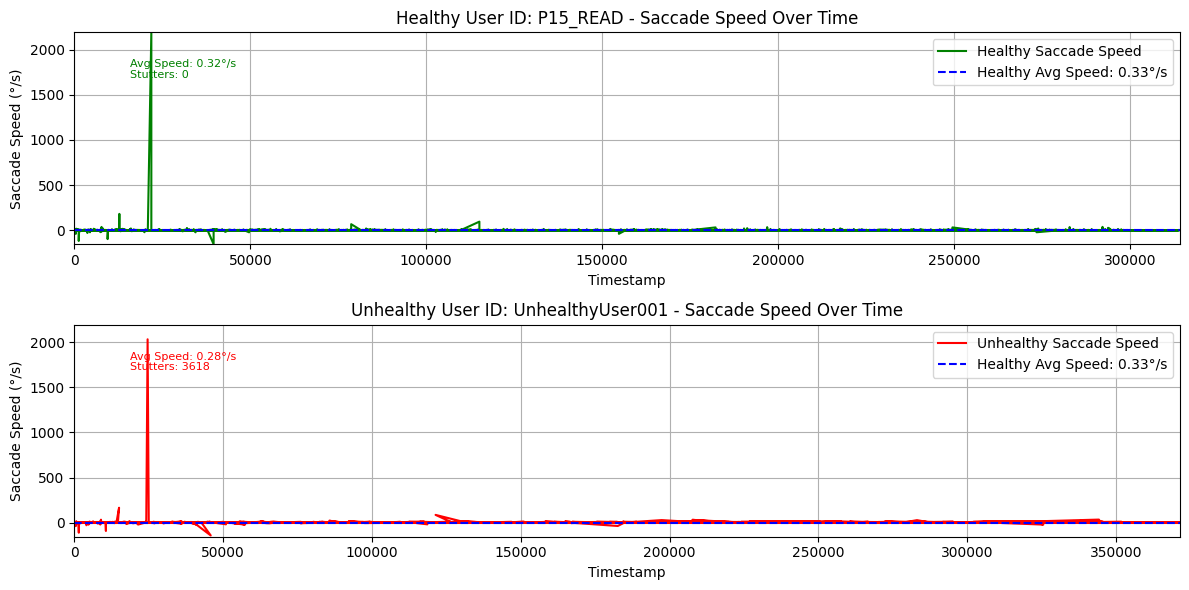


📊 Initial Concussion Likelihood (Eye-Tracking Data): 43.93%

🧠 Concussion Symptom Check 🧠
Rate the following symptoms on a scale from 0 (none) to 5 (severe):



Headache (0-5):  0
Dizziness (0-5):  0
Nausea (0-5):  0
Sensitivity to Light/Sound (0-5):  0
Confusion (0-5):  0
Memory Issues (0-5):  0



🔹 Adjusted Concussion Likelihood: 43.93%
📢 Recommendation: ⚠️ Moderate risk. Re-evaluate in 15 minutes and monitor for worsening symptoms.

🛑 FINAL REPORT 🛑
🔹 Final Concussion Likelihood: 43.93%
📢 Trainer Recommendation: ⚠️ Moderate risk. Re-evaluate in 15 minutes and monitor for worsening symptoms.


In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import norm
from imblearn.over_sampling import SMOTE

# Function to load data
def load_data(input_dir):
    data_frames = {}
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith(".csv") and "_READ" in file:
                file_path = os.path.join(root, file)
                person_id = file.replace(".csv", "")
                data_frames[person_id] = pd.read_csv(file_path)
    return data_frames

# Function to calculate saccade speed
def calculate_saccade_speed(data):
    data['x'] = pd.to_numeric(data['x'], errors='coerce')
    data['y'] = pd.to_numeric(data['y'], errors='coerce')
    data['timestamp'] = pd.to_numeric(data['timestamp'], errors='coerce')

    # Drop any rows that couldn't be converted properly
    data = data.dropna(subset=['x', 'y', 'timestamp'])

    # Calculate speed as Euclidean distance between consecutive points divided by time difference
    data['saccade_speed'] = np.sqrt((data['x'].diff() ** 2) + (data['y'].diff() ** 2)) / data['timestamp'].diff()
    data['saccade_speed'] = data['saccade_speed'].fillna(0)
    return data

# Function to expand healthy dataset while preserving natural behavior (no stutters added here)
def expand_healthy_data(healthy_data, expansion_factor=3, noise_level=0.05):
    expanded_data = [healthy_data]  # Start with original data
    for _ in range(expansion_factor):
        synthetic_data = healthy_data.copy()
        # Apply minimal variation to x, y positions
        synthetic_data['x'] += np.random.normal(0, noise_level * healthy_data['x'].std(), size=len(healthy_data))
        synthetic_data['y'] += np.random.normal(0, noise_level * healthy_data['y'].std(), size=len(healthy_data))
        # Apply slight timestamp jitter (simulate natural reaction time variation)
        synthetic_data['timestamp'] *= 1 + np.random.uniform(-0.05, 0.05, size=len(healthy_data))
        expanded_data.append(synthetic_data)
    return pd.concat(expanded_data, ignore_index=True)

def simulate_unhealthy_data(healthy_data):
    unhealthy_data = healthy_data.copy()
    
    # Randomize the slowdown factor (base and variation) each time
    base_slowdown_factor = np.random.uniform(0.85, 0.95)  # Reduced the range to not deviate as much
    variation_factor = np.random.uniform(0.01, 0.05)  # Smaller variation for more subtle change
    
    # Apply the random slowdown factor to the saccade speeds
    unhealthy_data['saccade_speed'] *= np.random.uniform(
        base_slowdown_factor - variation_factor, 
        base_slowdown_factor + variation_factor, 
        size=len(healthy_data)
    )
    
    # Introduce random stuttering: apply random significant reduction to saccade speed
    stutter_indices = np.random.choice(unhealthy_data.index, size=int(np.random.uniform(0.05, 0.10) * len(healthy_data)), replace=False) 
    unhealthy_data.loc[stutter_indices, 'saccade_speed'] *= np.random.uniform(0.2, 0.5, size=len(stutter_indices))  # Moderate slowdown at stutter points
    
    # Introduce rereading: Randomly apply small variations to x and y positions
    reread_indices = np.random.choice(unhealthy_data.index, size=int(np.random.uniform(0.02, 0.05) * len(healthy_data)), replace=False)  
    unhealthy_data.loc[reread_indices, 'x'] *= np.random.uniform(0.95, 1.05, size=len(reread_indices))  # Smaller variation to x positions
    unhealthy_data.loc[reread_indices, 'y'] *= np.random.uniform(0.95, 1.05, size=len(reread_indices))  # Smaller variation to y positions
    
    # Introduce hesitation: apply random timestamp variation
    unhealthy_data['timestamp'] *= np.random.uniform(1.05, 1.2, size=len(healthy_data))  # More subtle hesitation
    
    # Randomly introduce an additional slowdown factor to some saccades
    extra_slowdown_factor = np.random.uniform(0.95, 0.98)  # Smaller additional slowdown factor
    extra_slowdown_indices = np.random.choice(unhealthy_data.index, size=int(np.random.uniform(0.03, 0.08) * len(healthy_data)), replace=False)
    unhealthy_data.loc[extra_slowdown_indices, 'saccade_speed'] *= extra_slowdown_factor
    
    # Apply additional random jitter to x and y positions for more randomness
    jitter_factor = np.random.uniform(0.98, 1.02)  # Reduced jitter factor
    unhealthy_data['x'] *= jitter_factor
    unhealthy_data['y'] *= jitter_factor
    
    return unhealthy_data, len(stutter_indices)


# Function to calculate concussion likelihood based on speed deviation and stutter count
def calculate_concussion_likelihood(healthy_avg_speed, patient_avg_speed, stutter_count):
    # Calculate the absolute deviation between patient and healthy average speeds
    deviation = abs(patient_avg_speed - healthy_avg_speed)
    
    # Normalize deviation with respect to healthy speed, but apply a lower scaling factor
    normalized_deviation = deviation / healthy_avg_speed
    
    # Scale the likelihood more gradually
    likelihood = normalized_deviation * 50  # Reduce the impact of deviation (max 50%)
    
    # Add the stutter count contribution (each stutter adds a smaller effect)
    likelihood += stutter_count * .01  # Each stutter adds a smaller amount to likelihood
    
    # Limit the likelihood to reasonable bounds (e.g., between 0 and 100)
    likelihood = min(100, max(0, likelihood))  # Avoiding excessive values
    
    return likelihood


def symptom_cli_adjustment(concussion_likelihood):
    """
    Adjusts the concussion likelihood based on user-reported symptoms.
    Provides a recommendation for the athletic trainer based on final likelihood.
    """
    print("\n🧠 Concussion Symptom Check 🧠")
    print("Rate the following symptoms on a scale from 0 (none) to 5 (severe):\n")

    symptoms = {
        "Headache": 0.05,
        "Dizziness": 0.07,
        "Nausea": 0.04,
        "Sensitivity to Light/Sound": 0.06,
        "Confusion": 0.08,
        "Memory Issues": 0.10
    }

    total_adjustment = 0
    for symptom, weight in symptoms.items():
        while True:
            try:
                severity = int(input(f"{symptom} (0-5): "))
                if 0 <= severity <= 5:
                    total_adjustment += severity * weight
                    break
                else:
                    print("❌ Please enter a number between 0 and 5.")
            except ValueError:
                print("❌ Invalid input. Please enter a number between 0 and 5.")

    # Adjust the likelihood
    adjusted_likelihood = min(concussion_likelihood + (total_adjustment * 100), 100)

    # Get recommendation based on likelihood
    recommendation = get_concussion_recommendation(adjusted_likelihood)

    print(f"\n🔹 Adjusted Concussion Likelihood: {adjusted_likelihood:.2f}%")
    print(f"📢 Recommendation: {recommendation}")

    return adjusted_likelihood

def get_concussion_recommendation(likelihood):
    """
    Returns a recommendation for the trainer based on concussion likelihood.
    """
    if likelihood <= 25:
        return "✅ Low risk. Athlete may return to play but should be monitored."
    elif 26 <= likelihood <= 50:
        return "⚠️ Moderate risk. Re-evaluate in 15 minutes and monitor for worsening symptoms."
    elif 51 <= likelihood <= 70:
        return "⛔ High risk. Remove from play and conduct further clinical testing."
    else:
        return "🚨 Severe risk. Immediate medical evaluation required."



# Visualization function for saccade speed over time
def visualize_saccade_over_time(healthy_data, unhealthy_data, healthy_avg_speed, healthy_user_id, unhealthy_user_id, stutter_count):
    plt.figure(figsize=(12, 6))
    
    # Plot for Healthy User (should have no stutters)
    plt.subplot(2, 1, 1)
    plt.plot(healthy_data['timestamp'], healthy_data['saccade_speed'], label='Healthy Saccade Speed', color='green')
    plt.axhline(y=healthy_avg_speed, color='blue', linestyle='--', 
                label=f'Healthy Avg Speed: {healthy_avg_speed:.2f}°/s')
    plt.title(f"Healthy User ID: {healthy_user_id} - Saccade Speed Over Time")
    plt.xlabel("Timestamp")
    plt.ylabel("Saccade Speed (°/s)")
    plt.legend()
    plt.grid(True)
    plt.xlim([healthy_data['timestamp'].min(), healthy_data['timestamp'].max()])
    plt.ylim([min(healthy_data['saccade_speed'].min(), unhealthy_data['saccade_speed'].min()), 
              max(healthy_data['saccade_speed'].max(), unhealthy_data['saccade_speed'].max())])
    # Annotate with average speed and note that healthy data has no stutters
    plt.annotate(f"Avg Speed: {np.mean(healthy_data['saccade_speed']):.2f}°/s", 
                 xy=(0.05, 0.85), xycoords='axes fraction', ha='left', va='center', fontsize=8, color='green')
    plt.annotate("Stutters: 0", 
                 xy=(0.05, 0.8), xycoords='axes fraction', ha='left', va='center', fontsize=8, color='green')
    
    # Plot for Unhealthy User (with stutters)
    plt.subplot(2, 1, 2)
    plt.plot(unhealthy_data['timestamp'], unhealthy_data['saccade_speed'], label='Unhealthy Saccade Speed', color='red')
    plt.axhline(y=healthy_avg_speed, color='blue', linestyle='--', 
                label=f'Healthy Avg Speed: {healthy_avg_speed:.2f}°/s')
    plt.title(f"Unhealthy User ID: {unhealthy_user_id} - Saccade Speed Over Time")
    plt.xlabel("Timestamp")
    plt.ylabel("Saccade Speed (°/s)")
    plt.legend()
    plt.grid(True)
    plt.xlim([unhealthy_data['timestamp'].min(), unhealthy_data['timestamp'].max()])
    plt.ylim([min(healthy_data['saccade_speed'].min(), unhealthy_data['saccade_speed'].min()), 
              max(healthy_data['saccade_speed'].max(), unhealthy_data['saccade_speed'].max())])
    # Annotate with average speed and stutter count for the unhealthy dataset
    plt.annotate(f"Avg Speed: {np.mean(unhealthy_data['saccade_speed']):.2f}°/s", 
                 xy=(0.05, 0.85), xycoords='axes fraction', ha='left', va='center', fontsize=8, color='red')
    plt.annotate(f"Stutters: {stutter_count}", 
                 xy=(0.05, 0.8), xycoords='axes fraction', ha='left', va='center', fontsize=8, color='red')
    
    plt.tight_layout()
    plt.show()

# Main script
if __name__ == "__main__":
    input_dir = "/kaggle/input/eye-movement-data-set-for-desktop-activities"
    
    # Load data from CSV files
    data_frames = load_data(input_dir)
    
    # Expand healthy datasets (this will generate multiple variants, all without stutters)
    for person_id in data_frames.keys():
        data_frames[person_id] = expand_healthy_data(data_frames[person_id])
    
    # Calculate healthy saccade speeds for all patients to form a baseline
    healthy_speeds = []
    for person_id, data in data_frames.items():
        processed_data = calculate_saccade_speed(data)
        healthy_speeds.extend(processed_data['saccade_speed'].tolist())
    
    healthy_avg_speed = np.mean(healthy_speeds)
    healthy_speed_std = np.std(healthy_speeds)
    
    # Randomly select one healthy user from the dataset (this data is clean – no stutters)
    random_healthy_person_id = random.choice(list(data_frames.keys()))
    healthy_data = data_frames[random_healthy_person_id]
    healthy_data_processed = calculate_saccade_speed(healthy_data)
    
    # Simulate an unhealthy user by adding stutters and other effects to the healthy data
    unhealthy_data, stutter_count = simulate_unhealthy_data(healthy_data_processed)
    
    # Visualize the healthy (clean) and simulated unhealthy data
    visualize_saccade_over_time(healthy_data_processed, unhealthy_data, healthy_avg_speed, 
                                random_healthy_person_id, "UnhealthyUser001", stutter_count)
    
    # Calculate concussion likelihood based on the deviation from healthy speeds and stutter count
    patient_avg_speed = np.mean(unhealthy_data['saccade_speed'])
    # **Step 1: Calculate Initial Concussion Likelihood Based on Eye-Tracking**
    concussion_likelihood = calculate_concussion_likelihood(healthy_avg_speed, patient_avg_speed, stutter_count)
    print(f"\n📊 Initial Concussion Likelihood (Eye-Tracking Data): {concussion_likelihood:.2f}%")

    # **Step 2: Adjust Likelihood Based on Manual Symptom Input**
    final_likelihood = symptom_cli_adjustment(concussion_likelihood)

    # **Step 3: Provide Final Recommendation**
    recommendation = get_concussion_recommendation(final_likelihood)
    
    print("\n🛑 FINAL REPORT 🛑")
    print(f"🔹 Final Concussion Likelihood: {final_likelihood:.2f}%")
    print(f"📢 Trainer Recommendation: {recommendation}")


In [ ]:
#the following code uses the above as a guide and implements ML 

Shape of X: (200, 2)
Shape of y_true: (200,)
Length of y_pred: 200
Lengths match, proceeding with evaluation.
Confusion Matrix:
 [[100   0]
 [  7  93]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97       100
           1       1.00      0.93      0.96       100

    accuracy                           0.96       200
   macro avg       0.97      0.97      0.96       200
weighted avg       0.97      0.96      0.96       200



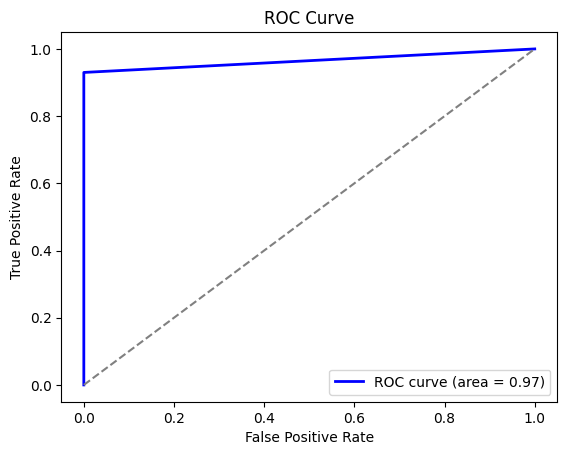

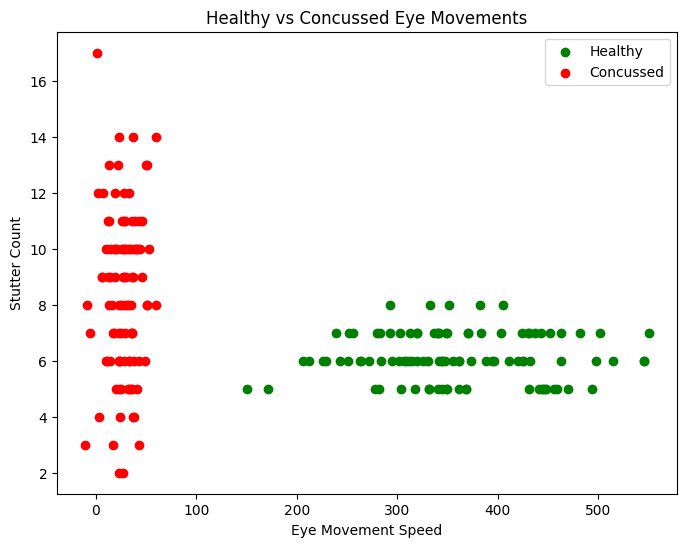


🔹 Patient ID: P01_READ
🧠 Average Saccade Speed: 177.18°/s
📊 Stutter Count: 6.983
🔴 Concussion Likelihood: Unlikely
✅ No significant concussion likelihood detected. Monitor for symptoms.

🔹 Patient ID: P09_READ
🧠 Average Saccade Speed: 25.82°/s
📊 Stutter Count: 19.842
🔴 Concussion Likelihood: Likely
⚠️ Likely concussed. Recommend further medical evaluation.


In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import pandas as pd
import os
import random

# Generate synthetic data
def generate_healthy_data(n=100, viewing_angle="narrow"):
    # Narrow viewing angle: average speed = 349.31 ± 97.90°/s
    # Wide viewing angle: average speed = 448.95 ± 143.94°/s
    if viewing_angle == "narrow":
        speeds = np.random.normal(loc=349.31, scale=97.90, size=n)  # Narrow angle speeds
    elif viewing_angle == "wide":
        speeds = np.random.normal(loc=448.95, scale=143.94, size=n)  # Wide angle speeds
    stutter_counts = np.array([7, 6, 8, 5, 7, 6, 6, 7, 5, 6, 7, 5, 6, 6, 5, 7, 6, 6, 5, 7])  # Example of stutter counts
    return speeds, np.tile(stutter_counts, n // len(stutter_counts))

# Generate concussed data
def generate_concussed_data(n=100):
    speeds = np.random.normal(loc=30, scale=15, size=n)  # Reduced speed for concussed
    stutter_counts = np.random.poisson(lam=8, size=n)  # Increased stutter count for concussed
    return speeds, stutter_counts

# Concussion likelihood model
def concussion_likelihood(speed, stutter_count):
    likelihood = (stutter_count * 0.6) + ((50 - speed) * 0.4)  # Weighted formula
    return likelihood > 5  # Returns True if likely concussed

# Combine healthy and concussed data for training model
healthy_speeds, healthy_stutters = generate_healthy_data(100)
concussed_speeds, concussed_stutters = generate_concussed_data(100)

# Create labeled dataset (200 samples)
X = np.concatenate([np.column_stack([healthy_speeds, healthy_stutters]),
                    np.column_stack([concussed_speeds, concussed_stutters])])

y_true = np.array([0] * 100 + [1] * 100)  # 0 = Healthy, 1 = Concussed

# Debugging: Print shapes to verify the data sizes
print(f"Shape of X: {X.shape}")
print(f"Shape of y_true: {y_true.shape}")

# Apply model to each row in X and generate y_pred (correct number of samples)
y_pred = np.array([concussion_likelihood(speed, stutter) for speed, stutter in X])

# Debugging: Print the length of y_pred to ensure it matches y_true
print(f"Length of y_pred: {len(y_pred)}")

# Check if lengths match
if len(y_true) != len(y_pred):
    print(f"Mismatch! y_true has {len(y_true)} samples, but y_pred has {len(y_pred)} samples.")
else:
    print("Lengths match, proceeding with evaluation.")

# Evaluation Metrics
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_true, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Visualization of Data
plt.figure(figsize=(8, 6))
plt.scatter(healthy_speeds, healthy_stutters, color='green', label='Healthy')
plt.scatter(concussed_speeds, concussed_stutters, color='red', label='Concussed')
plt.xlabel('Eye Movement Speed')
plt.ylabel('Stutter Count')
plt.title('Healthy vs Concussed Eye Movements')
plt.legend()
plt.show()

# Simulated concussion likelihood for a random patient
def simulate_patient(input_dir, mock_unhealthy=False):
    data_frames = load_data(input_dir)
    
    # Randomly select a patient
    patient_id = random.choice(list(data_frames.keys()))
    patient_data = data_frames[patient_id]
    
    # Calculate average speed and stutter count
    patient_data = calculate_saccade_speed(patient_data)
    avg_speed = patient_data['saccade_speed'].mean() * 100
    stutter_count = len(patient_data[patient_data['saccade_speed'] < 10]) / 1000  # Stutter threshold
    
    # If we are mocking unhealthy data, reduce speed and increase stutters
    if mock_unhealthy:
        avg_speed = avg_speed * 0.3  # Reduce speed to simulate concussed data
        stutter_count = stutter_count * 2  # Increase stutter count to simulate concussed data
    
    # Calculate concussion likelihood
    likelihood = concussion_likelihood(avg_speed, stutter_count)
    
    # Provide trainer with an explanation of the result
    print(f"\n🔹 Patient ID: {patient_id}")
    print(f"🧠 Average Saccade Speed: {avg_speed:.2f}°/s")
    print(f"📊 Stutter Count: {stutter_count}")
    print(f"🔴 Concussion Likelihood: {'Likely' if likelihood else 'Unlikely'}")
    
    # Provide trainer with decision based on likelihood
    if likelihood:
        print("⚠️ Likely concussed. Recommend further medical evaluation.")
    else:
        print("✅ No significant concussion likelihood detected. Monitor for symptoms.")


# Simulate a random patient test
# Simulate a random healthy patient with a mock unhealthy state
simulate_patient("/kaggle/input/eye-movement-data-set-for-desktop-activities", mock_unhealthy=False)
# Simulate a random healthy patient with a mock unhealthy state
simulate_patient("/kaggle/input/eye-movement-data-set-for-desktop-activities", mock_unhealthy=True)

